In [1]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scikit-learn
%pip install shap
%pip install econml

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [3]:
# Load dataset
df = pd.read_csv("../data.csv")

In [4]:
# Prepare covariates
X = df.drop(columns=["y", "z", "schoolid"])
X = pd.get_dummies(X, drop_first=True)
y = df["y"].values
t = df["z"].values

In [5]:
# Standardize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Define and fit Causal Forest DML model
cf_model = CausalForestDML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=42),
    model_t=RandomForestRegressor(n_estimators=100, random_state=42),
    n_estimators=100,
    min_samples_leaf=10,
    random_state=42,
    verbose=0
)

cf_model.fit(y, t, X=X_scaled)

In [7]:
# Predict CATE and ATE
cate_preds = cf_model.effect(X_scaled)
ate = np.mean(cate_preds)
ci = cf_model.ate_interval(X=X_scaled)

print(f"ATE (Causal Forest): {ate:.4f}")
print(f"95% Confidence Interval: [{ci[0]:.4f}, {ci[1]:.4f}]")

ATE (Causal Forest): 0.4154
95% Confidence Interval: [0.2079, 0.6230]


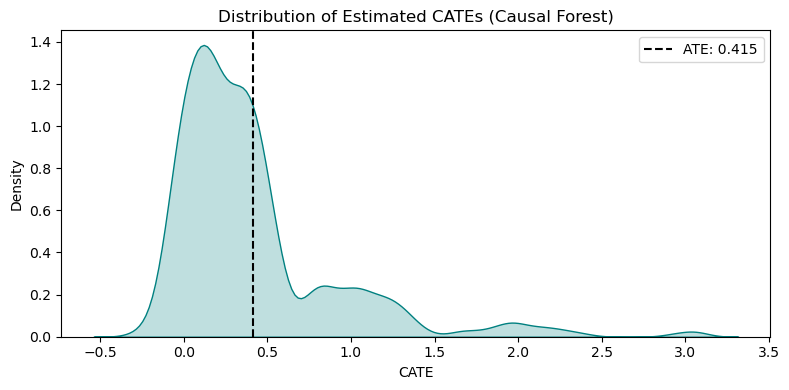

In [8]:
# Plot distribution of CATEs
plt.figure(figsize=(8, 4))
sns.kdeplot(cate_preds, fill=True, color="teal")
plt.axvline(ate, color="black", linestyle="--", label=f"ATE: {ate:.3f}")
plt.title("Distribution of Estimated CATEs (Causal Forest)")
plt.xlabel("CATE")
plt.legend()
plt.tight_layout()
plt.show()

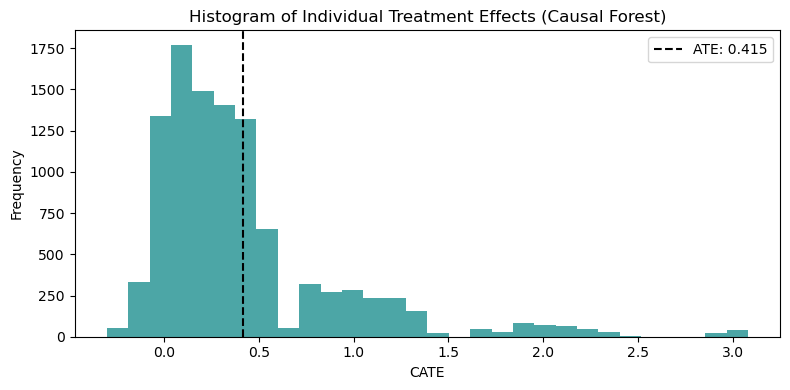

In [9]:
# Histogram of CATEs
plt.figure(figsize=(8, 4))
plt.hist(cate_preds, bins=30, color="teal", alpha=0.7)
plt.axvline(ate, color="black", linestyle="--", label=f"ATE: {ate:.3f}")
plt.title("Histogram of Individual Treatment Effects (Causal Forest)")
plt.xlabel("CATE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



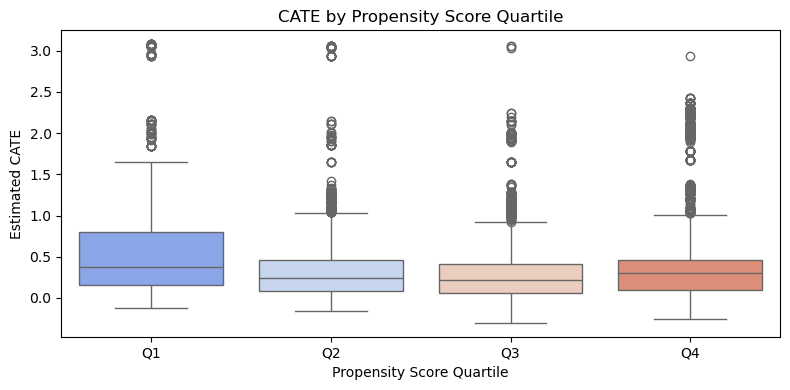

In [10]:
# CATE by Propensity Score Quartile
# Add pscore if needed
from sklearn.linear_model import LogisticRegression
X_ps = df.drop(columns=['y', 'z', 'schoolid'])
X_ps = pd.get_dummies(X_ps, drop_first=True)

ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_ps, df["z"])
df["pscore"] = ps_model.predict_proba(X_ps)[:, 1]

df["pscore_bin"] = pd.qcut(df["pscore"], 4, labels=["Q1", "Q2", "Q3", "Q4"])
df["cate"] = cate_preds

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x="pscore_bin", y="cate", palette="coolwarm")
plt.title("CATE by Propensity Score Quartile")
plt.xlabel("Propensity Score Quartile")
plt.ylabel("Estimated CATE")
plt.tight_layout()
plt.show()